In [ ]:
# !python3 idk.py --dapi 'A1ROI1_02_2_1Z4_Confocal DAPI_001.tif' --data 'data'

In [ ]:
import copy
import os

import cv2
import numpy as np
import pandas as pd
from cv2.typing import MatLike
from matplotlib import pyplot as plt
import re

In [ ]:
print(os.getcwd())

In [ ]:
DATA_DIR = "data"
OUTPUT_DIR = "out"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PLOT = True

In [43]:
def preprocess(gray: MatLike):
    """
    Preprocesses a grayscale image to create a binary mask for cell segmentation.
    """
    # apply Otsu's thresholding
    # might not be the best, as the intensities sometimes look overtuned
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    # apply morphological opening to remove small objects and noise
    # while preserving the shape of larger objects (cell clusters)
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel)

    return mask


def find_contours(dapi: MatLike, gfp: MatLike, tritc: MatLike, mask: MatLike, roi_name: str):
    """
    Identifies and visualizes cellular clusters by finding contours in the mask image.
    """

    # copy to avoid modifying original images
    segmented_img = copy.deepcopy(dapi)
    target_img = copy.deepcopy(gfp)
    target_img2 = copy.deepcopy(tritc)

    # find contours around the cell clusters
    contours, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    n = 0
    cluster_contours: list[MatLike] = []

    all_areas = [cv2.contourArea(c) for c in contours]
    # min_area_percentile = 98.0
    # contour_threshold = np.percentile(all_areas, min_area_percentile)
    contour_threshold = 2000

    # process each contour, filtering by area
    for i, contour in enumerate(contours):
        area = all_areas[i]
        if area > contour_threshold:
            cluster_contours.append(contour)

            # draw contour on all three images
            colour = (0, 255, 0)
            cv2.drawContours(segmented_img, contours, i, colour, 3)
            cv2.drawContours(target_img, contours, i, colour, 3)
            cv2.drawContours(target_img2, contours, i, colour, 3)

            n += 1

    print(f"  Found {n} clusters")

    if PLOT:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.canvas.manager.set_window_title(roi_name)
        ax1.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        ax1.set_title("DAPI")
        ax1.axis("off")
        ax2.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
        ax2.set_title("GFP")
        ax2.axis("off")
        ax3.imshow(cv2.cvtColor(target_img2, cv2.COLOR_BGR2RGB))
        ax3.set_title("TRITC")
        ax3.axis("off")
        plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
        plt.show()

    return cluster_contours


def build_histogram(channels: dict[str, MatLike], contours: list[MatLike], roi_name: str):
    """
    Calculates pixel intensity histograms for each cluster
    and saves the results to CSV files.
    """
    num_bins = 256
    bin_edges = np.arange(num_bins + 1)

    # nested dictionary that stores histogram data for each channel
    # {'ChannelName': {'Cluster_0': counts_array, 'Cluster_1': counts_array, ...}}
    channel_histograms = {name: {} for name in channels.keys()}

    # iterate over each cluster
    for i, cluster in enumerate(contours):
        # binary mask for the current cluster
        cluster_map = np.zeros_like(channels['GFP'], dtype=np.uint8)
        cv2.drawContours(cluster_map, [cluster], 0, [255.0], thickness=cv2.FILLED)

        # boolean mask for pixel selection
        mask_boolean = cluster_map > 0

        # iterate over each grayscale image
        for channel_name, gray_image in channels.items():
            # select pixels from the current grayscale image that fall within the cluster mask
            pixels_inside_contour = gray_image[mask_boolean]

            # calculate histogram
            if pixels_inside_contour.size > 0:
                histogram_counts, _ = np.histogram(
                    pixels_inside_contour, bins=bin_edges
                )
                column_name = f"Cluster_{i+1}"
                channel_histograms[channel_name][column_name] = histogram_counts

    # save the histogram data
    print(f"\nSaving histogram data for ROI: {roi_name}")
    for channel_name, histograms_dict in channel_histograms.items():
        if not histograms_dict:
            print(f"  Skipping channel {channel_name}: No cluster data found.")
            continue

        final_df = pd.DataFrame(histograms_dict)
        final_df.insert(0, "Intensity", np.arange(num_bins))

        output_filename = os.path.join(OUTPUT_DIR, f"{roi_name}_{channel_name}.csv")
        # output_filename = os.path.join(OUTPUT_DIR, f"{roi_name}_{channel_name}.xlsm")
        try:
            final_df.to_csv(output_filename, index=False)
            # final_df.to_excel(output_filename)
            print(
                f"  Successfully saved {channel_name} histogram data to {output_filename}"
            )
        except Exception as e:
            print(
                f"  Error saving CSV file for {channel_name} to {output_filename}: {e}"
            )

def run(out_name, dapi_path, gfp_path, tritc_path):
    dapi = cv2.imread(os.path.join(DATA_DIR, dapi_path))
    dapi_gray = cv2.cvtColor(dapi, cv2.COLOR_BGR2GRAY)
    # print(dapi_gray.shape, dapi_gray.dtype)

    gfp = cv2.imread(os.path.join(DATA_DIR, gfp_path))
    gfp_gray = cv2.cvtColor(gfp, cv2.COLOR_BGR2GRAY)

    tritc = cv2.imread(os.path.join(DATA_DIR, tritc_path))
    tritc_gray = cv2.cvtColor(tritc, cv2.COLOR_BGR2GRAY)

    print(f"\nAnalysing: {out_name}")

    print("Step 1: Preprocessing DAPI image...")
    mask = preprocess(dapi_gray)

    print("Step 2: Finding contours...")
    clusters = find_contours(dapi, gfp, tritc, mask, out_name)

    if clusters:
        print("Step 3: Building GFP and TRITC histograms for clusters...")
        channels = {"GFP": gfp_gray, "TRITC": tritc_gray}
        build_histogram(channels, clusters, out_name)
    else:
        print("Skipping histogram generation as no clusters met the criteria.")

    print('---------------------------------------')

    print("\nDone :D")


A1ROI2_02_2_1Z4_Confocal DAPI_001.tif A1ROI2_02_3_1Z4_Confocal GFP_001.tif A1ROI2_02_4_1Z4_Confocal TRITC_001.tif

Analysing: A1ROI2_1Z4_Confocal 
Step 1: Preprocessing DAPI image...
Step 2: Finding contours...
  Found 3 clusters


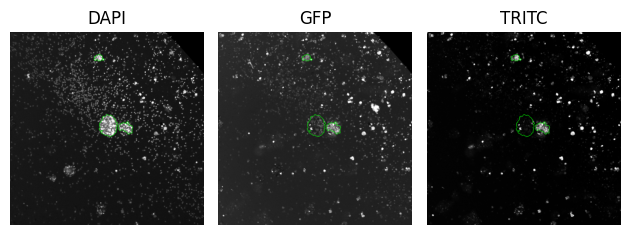

Step 3: Building GFP and TRITC histograms for clusters...

Saving histogram data for ROI: A1ROI2_1Z4_Confocal 
  Successfully saved GFP histogram data to out/A1ROI2_1Z4_Confocal _GFP.csv
  Successfully saved TRITC histogram data to out/A1ROI2_1Z4_Confocal _TRITC.csv
---------------------------------------

Done :D


In [45]:
dapi_path = 'A1ROI2_02_2_1Z4_Confocal DAPI_001.tif'

pattern = re.compile(r"^(.*_)(\d)(_.*_Confocal )([A-Z]+)(_.*\.tif)$")
match = pattern.match(dapi_path)

if match:
    prefix = match.group(1)
    middle = match.group(3)
    suffix = match.group(5)
    
    gfp_path = f"{prefix}3{middle}GFP{suffix}"
    tritc_path = f"{prefix}4{middle}TRITC{suffix}"

else:
    print(f"Error: The input path '{dapi_path}' does not match the expected pattern.")
    quit()

print(dapi_path, gfp_path, tritc_path)
out_name = dapi_path.split("_")[0] + middle

run(out_name, dapi_path, gfp_path, tritc_path)